RESNET34

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34, ResNet34_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])


train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
model = model.to(device)

100%|██████████| 169M/169M [00:30<00:00, 5.56MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 10
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=running_loss / len(train_loader))

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/10: 100%|██████████| 782/782 [02:18<00:00,  5.67it/s, loss=2.28]


Epoch [1/10], Loss: 2.2758, Accuracy: 0.4504


Epoch 2/10: 100%|██████████| 782/782 [02:12<00:00,  5.92it/s, loss=1.54]


Epoch [2/10], Loss: 1.5434, Accuracy: 0.5796


Epoch 3/10: 100%|██████████| 782/782 [02:05<00:00,  6.22it/s, loss=1.42]


Epoch [3/10], Loss: 1.4198, Accuracy: 0.6060


Epoch 4/10: 100%|██████████| 782/782 [02:04<00:00,  6.28it/s, loss=1.36]


Epoch [4/10], Loss: 1.3605, Accuracy: 0.6195


Epoch 5/10: 100%|██████████| 782/782 [01:55<00:00,  6.75it/s, loss=1.32]


Epoch [5/10], Loss: 1.3232, Accuracy: 0.6279


Epoch 6/10: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s, loss=1.29]


Epoch [6/10], Loss: 1.2936, Accuracy: 0.6361


Epoch 7/10: 100%|██████████| 782/782 [01:56<00:00,  6.74it/s, loss=1.27]


Epoch [7/10], Loss: 1.2701, Accuracy: 0.6396


Epoch 8/10: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s, loss=1.26]


Epoch [8/10], Loss: 1.2553, Accuracy: 0.6460


Epoch 9/10: 100%|██████████| 782/782 [01:56<00:00,  6.71it/s, loss=1.24]


Epoch [9/10], Loss: 1.2354, Accuracy: 0.6506


Epoch 10/10: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s, loss=1.22]

Epoch [10/10], Loss: 1.2240, Accuracy: 0.6517


In [ ]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
correct, total = 0, 0

progress_bar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Compute class probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total

Evaluating: 100%|██████████| 157/157 [00:22<00:00,  6.86it/s]


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6109
Precision: 0.6334
Recall: 0.6109
F1-Score: 0.6090


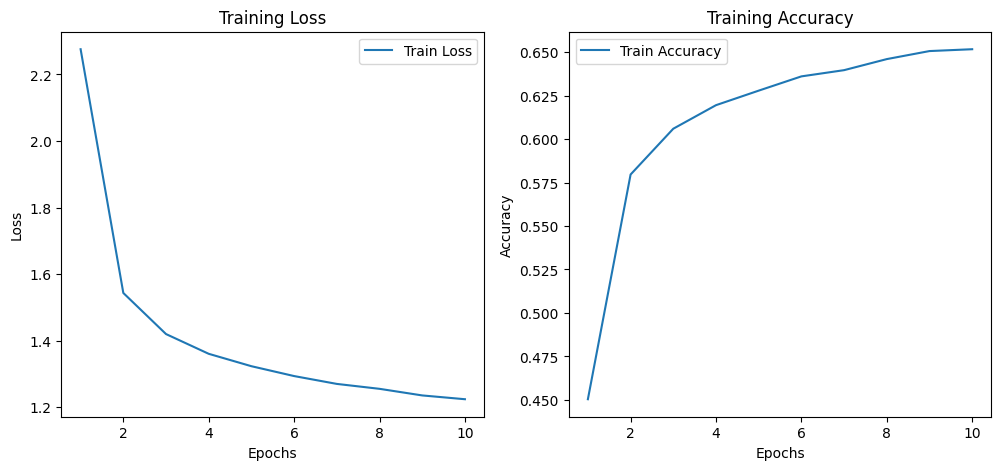

In [ ]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()

RESNET18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
model = model.to(device)


for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [ ]:
num_epochs = 10
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=running_loss / len(train_loader))

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/10: 100%|██████████| 782/782 [01:37<00:00,  8.06it/s, loss=2.37]


Epoch [1/10], Loss: 2.3722, Accuracy: 0.4290


Epoch 2/10: 100%|██████████| 782/782 [01:39<00:00,  7.88it/s, loss=1.63]


Epoch [2/10], Loss: 1.6322, Accuracy: 0.5590


Epoch 3/10: 100%|██████████| 782/782 [01:36<00:00,  8.12it/s, loss=1.5]


Epoch [3/10], Loss: 1.5034, Accuracy: 0.5865


Epoch 4/10: 100%|██████████| 782/782 [01:38<00:00,  7.98it/s, loss=1.44]


Epoch [4/10], Loss: 1.4371, Accuracy: 0.6015


Epoch 5/10: 100%|██████████| 782/782 [01:37<00:00,  8.06it/s, loss=1.39]


Epoch [5/10], Loss: 1.3913, Accuracy: 0.6090


Epoch 6/10: 100%|██████████| 782/782 [01:37<00:00,  8.01it/s, loss=1.36]


Epoch [6/10], Loss: 1.3603, Accuracy: 0.6185


Epoch 7/10: 100%|██████████| 782/782 [01:36<00:00,  8.10it/s, loss=1.34]


Epoch [7/10], Loss: 1.3359, Accuracy: 0.6255


Epoch 8/10: 100%|██████████| 782/782 [01:38<00:00,  7.98it/s, loss=1.32]


Epoch [8/10], Loss: 1.3192, Accuracy: 0.6268


Epoch 9/10: 100%|██████████| 782/782 [01:38<00:00,  7.95it/s, loss=1.3]


Epoch [9/10], Loss: 1.3022, Accuracy: 0.6298


Epoch 10/10: 100%|██████████| 782/782 [01:38<00:00,  7.96it/s, loss=1.29]

Epoch [10/10], Loss: 1.2902, Accuracy: 0.6344


In [ ]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
correct, total = 0, 0

progress_bar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Compute class probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total

Evaluating: 100%|██████████| 157/157 [00:20<00:00,  7.77it/s]


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5818
Precision: 0.6043
Recall: 0.5818
F1-Score: 0.5798


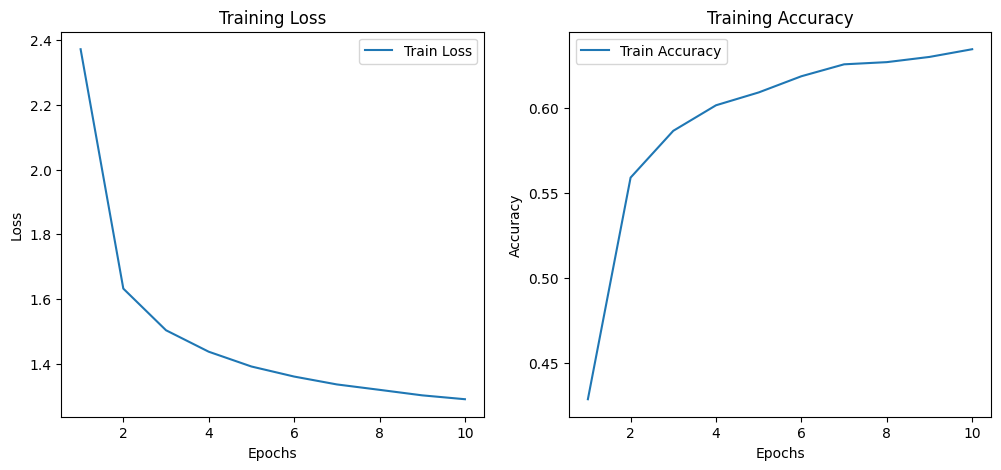

In [ ]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()

MetaLearning Pipeline

In [ ]:
import torch
import random
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2


transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]


In [ ]:
images = mnist_data.data.float() / 255.0
labels = mnist_data.targets


alpha = 10
sigma = 3


random_state = np.random.RandomState(None)
dx = cv2.GaussianBlur((random_state.rand(28, 28) * 2 - 1), (3, 3), sigma) * alpha
dy = cv2.GaussianBlur((random_state.rand(28, 28) * 2 - 1), (3, 3), sigma) * alpha
x, y = np.meshgrid(np.arange(28), np.arange(28))
map_x = np.float32(x + dx)
map_y = np.float32(y + dy)

In [ ]:
for i in range(len(images)):
    images[i] = torch.tensor(cv2.remap(images[i].numpy(), map_x, map_y, interpolation=cv2.INTER_LINEAR))


train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_images, test_images = images[:train_size], images[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]


N = 5  # Number of classes per episode
K = 5  # Number of support samples per class
Q = 3  # Number of query samples per class


selected_classes = random.sample(range(10), N)


support_images, support_labels = [], []
query_images, query_labels = [], []

In [ ]:
for cls in selected_classes:
    class_indices = torch.where(train_labels == cls)[0]
    selected_samples = torch.randperm(len(class_indices))

    support_indices = class_indices[selected_samples[:K]]
    query_indices = class_indices[selected_samples[K:K+Q]]

    support_images.append(train_images[support_indices])
    support_labels.append(torch.full((K,), cls))
    query_images.append(train_images[query_indices])
    query_labels.append(torch.full((Q,), cls))

FEW SHOT LEARNING MODEL

In [ ]:
support_images = torch.cat(support_images, dim=0)
support_labels = torch.cat(support_labels)
query_images = torch.cat(query_images, dim=0)
query_labels = torch.cat(query_labels)

In [ ]:
support_images = support_images.view(support_images.shape[0], -1)  # Shape: (N*K, 784)
query_images = query_images.view(query_images.shape[0], -1)  # Shape: (N*Q, 784)

In [ ]:
prototypes = []
prototype_labels = torch.tensor(selected_classes)  # Track labels

for cls in selected_classes:
    class_indices = torch.where(support_labels == cls)[0]
    if class_indices.numel() == 0:
        continue
    class_prototype = support_images[class_indices].mean(dim=0)
    prototypes.append(class_prototype)

prototypes = torch.stack(prototypes)

In [ ]:
query_distances = []
for i in range(len(query_images)):
    distances = torch.norm(prototypes - query_images[i].unsqueeze(0), dim=1)
    predicted_class = prototype_labels[torch.argmin(distances)].item()  # Map to actual label
    query_distances.append(predicted_class)

correct = (torch.tensor(query_distances) == query_labels).sum().item()
accuracy = correct / len(query_labels) * 100
print(f"Prototypical Network Accuracy: {accuracy:.2f}%")

Prototypical Network Accuracy: 73.33%


SIAMESE NETWORK

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
feature_extractor = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU()
)

In [ ]:
fc = nn.Linear(256 * 28 * 28, 128)

In [ ]:
support_embeddings = []
query_embeddings = []

In [ ]:
for img in support_images:
    img = img.unsqueeze(0).unsqueeze(0)
    x = feature_extractor(img)
    x = x.view(1, -1)
    embedding = fc(x)
    support_embeddings.append(embedding)

for img in query_images:
    img = img.unsqueeze(0).unsqueeze(0)
    x = feature_extractor(img)
    x = x.view(1, -1)
    embedding = fc(x)
    query_embeddings.append(embedding)

support_embeddings = torch.cat(support_embeddings)
query_embeddings = torch.cat(query_embeddings)

In [ ]:
prototypes = []
for cls in selected_classes:
    indices = torch.where(support_labels == cls)[0]
    class_prototype = support_embeddings[indices].mean(dim=0)
    prototypes.append(class_prototype)

In [ ]:
prototypes = torch.stack(prototypes)


query_distances = []
for i in range(len(query_embeddings)):
    distances = torch.norm(prototypes - query_embeddings[i].unsqueeze(0), dim=1)
    predicted_class = selected_classes[torch.argmin(distances).item()]
    query_distances.append(predicted_class)

query_distances = torch.tensor(query_distances)
correct = (query_distances == query_labels).sum().item()
accuracy = correct / len(query_labels) * 100
print(f"Siamese Network Accuracy: {accuracy:.2f}%")

Siamese Network Accuracy: 73.33%


MATCHING NETWORK

In [ ]:
cosine_similarities = torch.nn.functional.cosine_similarity(
    support_embeddings.unsqueeze(0),
    query_embeddings.unsqueeze(1),
    dim=2
)

cosine_similarities = cosine_similarities.view(len(query_embeddings), len(selected_classes), K).mean(dim=2)

predicted_indices = torch.argmax(cosine_similarities, dim=1)
query_predictions = torch.tensor([selected_classes[i] for i in predicted_indices])

correct = (query_predictions == query_labels).sum().item()
accuracy = correct / len(query_labels) * 100
print(f"Matching Network Accuracy: {accuracy:.2f}%")


Matching Network Accuracy: 60.00%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

y_true = query_labels.cpu().numpy()

y_pred_proto = np.array(query_distances)
y_pred_siamese = np.array(query_distances)
y_pred_matching = query_predictions.clone().detach().cpu().numpy()

precision_proto = precision_score(y_true, y_pred_proto, average='macro')
recall_proto = recall_score(y_true, y_pred_proto, average='macro')
f1_proto = f1_score(y_true, y_pred_proto, average='macro')

print(f"Prototypical Networks - Precision: {precision_proto:.2f}, Recall: {recall_proto:.2f}, F1-score: {f1_proto:.2f}")

Prototypical Networks - Precision: 0.73, Recall: 0.73, F1-score: 0.72
